In [1]:
from alphablokus.files import *
from alphablokus.configs import GameConfig, NetworkConfig
from alphablokus.train_utils import *

In [2]:
game_config = GameConfig("/Users/shivamsarodia/Dev/AlphaBlokus/configs/training/full_vast.toml")
network_config = NetworkConfig("/Users/shivamsarodia/Dev/AlphaBlokus/configs/training/full_vast.toml")

In [ ]:
# def load_game_file_special(
#     game_config: GameConfig,
#     local_file_path: str,
# ) -> tuple[List[torch.Tensor], List[torch.Tensor], List[torch.Tensor], List[torch.Tensor]]:
#     boards = []
#     values = []
#     policies = []
#     valid_move_tupleses = []
#     with zstandard.open(local_file_path, "rb") as f:
#         game_data_list = f.read()
#         game_data_list = msgpack.unpackb(game_data_list)

#         for game_data in game_data_list:
#             board = [game_data["board"]["slices"][i]["cells"] for i in range(4)]
#             boards.append(torch.as_tensor(board, dtype=torch.float32))

#             values.append(torch.as_tensor(game_data["game_result"]))

#             policy_target = torch.zeros(
#                 (
#                     game_config.num_piece_orientations,
#                     game_config.board_size,
#                     game_config.board_size,
#                 ),
#                 dtype=torch.float32,
#             )

#             valid_move_tuples = torch.as_tensor(
#                 game_data["valid_move_tuples"], dtype=torch.int32
#             )
#             visit_counts = torch.as_tensor(
#                 game_data["visit_counts"], dtype=torch.float32
#             )

#             policy_target[
#                 valid_move_tuples[:, 0],
#                 valid_move_tuples[:, 1],
#                 valid_move_tuples[:, 2],
#             ] = visit_counts

#             policies.append(policy_target / policy_target.sum())

#             valid_move_tupleses.append(valid_move_tuples)

#     return boards, values, policies, valid_move_tupleses

In [4]:
board, expected_value, expected_policies, valid_masks = load_game_file(
    game_config,
    "/Users/shivamsarodia/Dev/AlphaBlokus/data/s3_mirrors/full/games/2025-12-14_14-56-12-305253677-44479286_10006.bin",
)

In [5]:
initial_training_path = localize_file("s3://alpha-blokus/full/training_simulated/04413189invalid_ignored_1767006076.pth")
model = initialize_model(network_config, game_config)
initial_training_state = torch.load(
    initial_training_path, map_location="cpu",
)
model.load_state_dict(initial_training_state["model"])

Created temporary directory: /var/folders/np/v76cnj490z525wk67wqh68dc0000gn/T/tmpnfypq853


<All keys matched successfully>

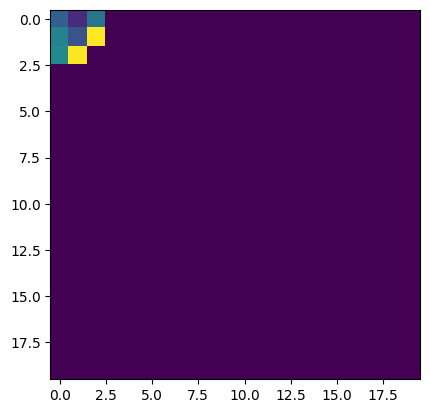

tensor([[0.3104, 0.1406, 0.3965, 0.0110, 0.0110, 0.0110, 0.0110, 0.0110, 0.0110,
         0.0110, 0.0110, 0.0110, 0.0110, 0.0110, 0.0110, 0.0110, 0.0110, 0.0110,
         0.0110, 0.0110],
        [0.4493, 0.2677, 1.0000, 0.0110, 0.0110, 0.0110, 0.0110, 0.0110, 0.0110,
         0.0110, 0.0110, 0.0110, 0.0110, 0.0110, 0.0110, 0.0110, 0.0110, 0.0110,
         0.0110, 0.0110],
        [0.4860, 1.0000, 0.0110, 0.0110, 0.0110, 0.0110, 0.0110, 0.0110, 0.0110,
         0.0110, 0.0110, 0.0110, 0.0110, 0.0110, 0.0110, 0.0110, 0.0110, 0.0110,
         0.0110, 0.0110],
        [0.0110, 0.0110, 0.0110, 0.0110, 0.0110, 0.0110, 0.0110, 0.0110, 0.0110,
         0.0110, 0.0110, 0.0110, 0.0110, 0.0110, 0.0110, 0.0110, 0.0110, 0.0110,
         0.0110, 0.0110],
        [0.0110, 0.0110, 0.0110, 0.0110, 0.0110, 0.0110, 0.0110, 0.0110, 0.0110,
         0.0110, 0.0110, 0.0110, 0.0110, 0.0110, 0.0110, 0.0110, 0.0110, 0.0110,
         0.0110, 0.0110],
        [0.0110, 0.0110, 0.0110, 0.0110, 0.0110, 0.0110, 0.0

NameError: name 'policy' is not defined

In [14]:
i = 0

model.eval()
with torch.no_grad():
    value, pred_policy = model(torch.stack(board[:128]))

valid_masks_torch = torch.stack(valid_masks)[:128]
pred_policy = pred_policy.view(pred_policy.shape[0], -1)
valid_policy_mask = valid_masks_torch.view(valid_masks_torch.shape[0], -1)
pred_policy[~valid_policy_mask] = -1e6

norm_policy = torch.softmax(pred_policy.view(128, 91, 20, 20)[0], dim=0)

import matplotlib.pyplot as plt
plt.imshow(norm_policy.amax(dim=0))
plt.show()

print(norm_policy.amax(dim=0))

# valid_moves = valid_move_tupleses[0]
# policy_flat = []
# for o, x, y in valid_moves:
#     policy_flat.append(policy[o, x, y])

# policy_flat = torch.tensor(policy_flat)
# sorted_python_policy = [float(f) for f in torch.softmax(policy_flat, dim=0)]
# sorted_rust_policy = [0.0017804487, 0.0012749631, 0.0030674587, 0.001635297, 0.003091517, 0.0012761067, 0.0025026426, 0.0014948365, 0.001655499, 0.0015993566, 0.0014041491, 0.0025089025, 0.0014337483, 0.0023060855, 0.0012225262, 0.002168894, 0.0018361353, 0.0012759309, 0.0007263659, 0.001536489, 0.0025056598, 0.0011082556, 0.0010678461, 0.0014937265, 0.001694649, 0.001740352, 0.0013038054, 0.0014627489, 0.0023920636, 0.0028272392, 0.0023846098, 0.0024700197, 0.0026663302, 0.0014198576, 0.0019940138, 0.0016917731, 0.0020160847, 0.0033128285, 0.002630037, 0.0030163215, 0.0019877777, 0.003638182, 0.0034990376, 0.005224904, 0.0022628529, 0.0021252548, 0.0025253159, 0.0010097863, 0.0027865146, 0.0016451078, 0.0013178671, 0.0016964761, 0.0032936437, 0.0013674902, 0.0032552404, 0.0012929739, 0.0017626014, 0.0024071478, 0.0012407874, 0.0015006536, 0.0016186206, 0.0036599706, 0.0014512632, 0.0022196292, 0.0015245879, 0.0024985992, 0.0035290192, 0.0013759101, 0.0042922283, 0.0014099829, 0.0024304572, 0.0026751137, 0.0016967197, 0.0048578167, 0.0020672446, 0.0023071733, 0.0017793514, 0.0027407599, 0.0020478813, 0.0016809249, 0.0028276816, 0.0019442926, 0.0027889537, 0.0016585189, 0.0014739388, 0.0011484708, 0.001281637, 0.0015912339, 0.0010070191, 0.03102252, 0.0027917572, 0.0017671653, 0.0022982135, 0.003257012, 0.0016731472, 0.0033966822, 0.0016079661, 0.0030861397, 0.0016645394, 0.0026785957, 0.0014073371, 0.004738274, 0.0011782562, 0.0037811503, 0.0024302464, 0.002598609, 0.0014350534, 0.0016134084, 0.5608279, 0.01158466, 0.012897135, 0.0031994423, 0.00257758, 0.0022617967, 0.0025820865, 0.0018169048, 0.0016530466, 0.002136029, 0.0022113784, 0.0012890575, 0.003528188, 0.0023806358, 0.0024999185, 0.004043784, 0.00309022, 0.00215227, 0.0025737423, 0.0019437595, 0.001615705, 0.001317203, 0.0057044197, 0.0017804666, 0.0021051643, 0.0016722045, 0.0011885681, 0.0013876687, 0.0012440482, 0.0010733881, 0.0018168753, 0.0018037991, 0.0022736709, 0.0024634763, 0.0017476927, 0.0019324921, 0.0012812784, 0.0012280019, 0.0016395038, 0.001788657, 0.0016512425, 0.0016208164, 0.0011417072, 0.0012962635, 0.0015969401, 0.0009760605, 0.0015365909, 0.002012598, 0.0015660793, 0.0013389939, 0.001726807, 0.0013515025, 0.0016086502, 0.0014117785, 0.0016931717, 0.0008701847, 0.002975071, 0.0025440105, 0.0023046115, 0.0019982695, 0.0019687503, 0.0023873437, 0.0019637118, 0.001871375, 0.0018478971, 0.0018877151, 0.0016184006, 0.00117461, 0.001040889, 0.0012791192, 0.0017524235, 0.0011982226, 0.0010310115, 0.001238083, 0.0015843525, 0.0011658403, 0.0014472068, 0.0015953768, 0.001451455, 0.0015283204, 0.0018247841, 0.0008750439, 0.0011111558, 0.0008891214, 0.001087634, 0.0013476778, 0.0009939816, 0.0011907271, 0.0012663469]

# visit_counts = []
# for o, x, y in valid_moves:
#     visit_counts.append(expected_policy[o, x, y])

# for py, rust, visit_count in zip(sorted_python_policy, sorted_rust_policy, visit_counts):
#     print(f"{py:.6f} {visit_count}")

# torch.nozero(expected_policy)
# # print(torch.softmax(value, dim=1))

# pred_policy = policy.view(policy.shape[0], -1)
# print(torch.softmax(pred_policy, dim=1))
# # expected_policy = expected_policy.view(expected_policy.shape[0], -1)
# # policy_loss = training_config.policy_loss_weight * nn.CrossEntropyLoss()(
# #     pred_policy, expected_policy
# #)

# print(policy.shape)
print(policy[valid_move_tupleses[i]])

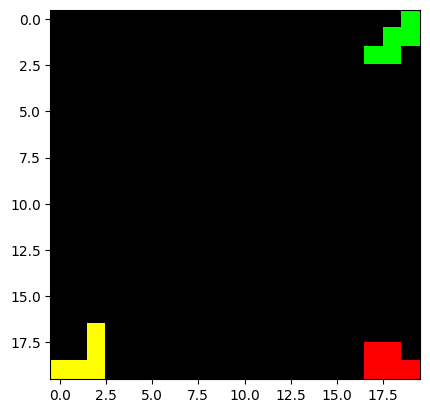

In [254]:
import matplotlib.pyplot as plt
import numpy as np

np_board = board[i].numpy(force=True)

output = np.zeros((20, 20, 3), dtype=np.float32)

# Blue for player 0
output[:, :, 2] = np_board[0] * 1.0

# Yellow for player 1
output[:, :, 0] += np_board[1] * 1.0
output[:, :, 1] += np_board[1] * 1.0

# Red for player 2
output[:, :, 0] += np_board[2] * 1.0

# Green for player 3
output[:, :, 1] += np_board[3] * 1.0

plt.imshow(output)
plt.show()

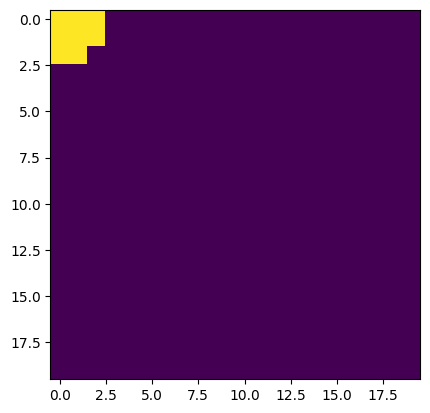

In [238]:
valid_move_centers = np.zeros((20, 20))
for tup in valid_move_tupleses[i]:
    valid_move_centers[tup[1], tup[2]] = 1
plt.imshow(valid_move_centers)
plt.show()

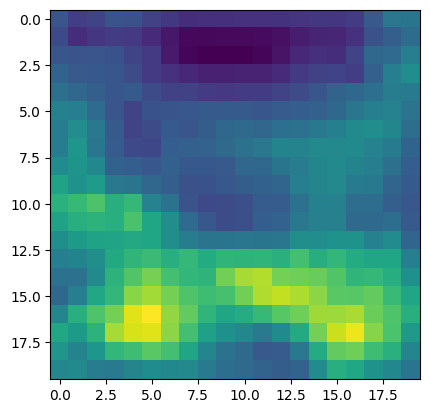

In [224]:
import matplotlib.pyplot as plt
plt.imshow(policy.sum(dim=0))
plt.show()

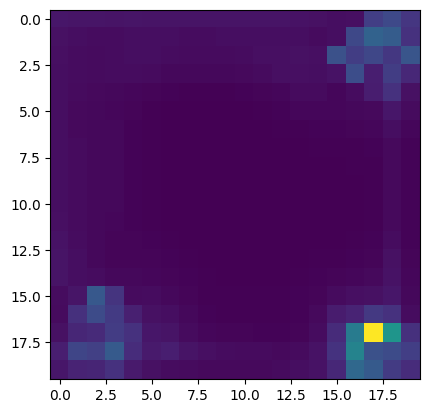

In [252]:
policy[~valid_move_tupleses[i]] = -1e6
original_shape = policy.shape

norm_policy = policy.view(policy.shape[0], -1)
norm_policy = torch.softmax(norm_policy, dim=1)
norm_policy = norm_policy.view(original_shape)

import matplotlib.pyplot as plt
plt.imshow(norm_policy.sum(dim=0))
plt.show()

In [174]:
policy.shape

torch.Size([91, 20, 20])

In [167]:
policy.shape

torch.Size([91, 20, 20])

In [138]:
pred_policy.shape

torch.Size([128, 91, 20, 20])

In [144]:
expected_policies_batch = torch.stack(expected_policies[:128])
pred_policy_view = pred_policy.view(pred_policy.shape[0], -1)
expected_policy_view = expected_policies_batch.view(expected_policies_batch.shape[0], -1)
policy_loss = nn.CrossEntropyLoss()(
    pred_policy_view, expected_policy_view
)

In [162]:
torch.softmax(pred_policy_view[0], dim=0)[5221]

tensor(0.1919)

In [160]:
expected_policy_view[0][5221]

tensor(0.2600)

In [156]:
sum(expected_policy_view[0])

tensor(1.0000)

In [145]:
policy_loss

tensor(4.1211)

In [126]:
pred_policy_view

tensor([[-10.5207, -15.4811, -14.5288,  ..., -30.5330, -28.8845, -27.1768]])

In [127]:
expected_policy_view

tensor([[0., 0., 0.,  ..., 0., 0., 0.]])

In [3]:
import boto3

s3 = boto3.client(
    "s3",
    aws_access_key_id=os.getenv("AWS_ACCESS_KEY_ID"),
    aws_secret_access_key=os.getenv("AWS_SECRET_ACCESS_KEY"),
    region_name=os.getenv("AWS_REGION_NAME"),
    endpoint_url=os.getenv("AWS_ENDPOINT_URL"),
)

In [ ]:
src_key = "full/training/00000000.pth"
dst_key = "full_v2/training/00000000.pth"

s3.copy_object(
    Bucket="alpha-blokus",
    CopySource={"Bucket": "alpha-blokus", "Key": src_key},
    Key=dst_key,
)

{'ResponseMetadata': {'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Tue, 30 Dec 2025 01:05:23 GMT',
   'content-type': 'application/xml',
   'content-length': '233',
   'connection': 'keep-alive',
   'x-amz-copy-source-version-id': '7e656506e76780484adac53bca9fd36e',
   'x-amz-version-id': '7e64933634ecedfa38ce07940dba402d',
   'vary': 'Accept-Encoding',
   'server': 'cloudflare',
   'cf-ray': '9b5da0e3eb7ff973-SJC'},
  'RetryAttempts': 0},
 'CopySourceVersionId': '7e656506e76780484adac53bca9fd36e',
 'VersionId': '7e64933634ecedfa38ce07940dba402d',
 'CopyObjectResult': {'ETag': '"c464dac98ea449fc3321a826fe199e9c"',
  'LastModified': datetime.datetime(2025, 12, 30, 1, 5, 23, 222000, tzinfo=tzutc())}}